In [1]:
from kaggle_secrets import UserSecretsClient
import wandb

# Lấy secret từ Kaggle secrets manager
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("WANDB_API_KEY")

# Đăng nhập wandb
wandb.login(key=wandb_api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hoangviet852004 (hoangviet852004-vku) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
# 1. Import libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
from tqdm import tqdm
import timm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# 2. Path dataset
# /kaggle/input/fracture-bone-dataset/Bone_Fracture_Binary_Classification/test
train_path = "/kaggle/input/Bone_Fracture_Binary_Classification/train/"
val_path = "/kaggle/input/Bone_Fracture_Binary_Classification/val/"
test_path = "/kaggle/input/Bone_Fracture_Binary_Classification/test/"

In [4]:
# 3. Get image paths
def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

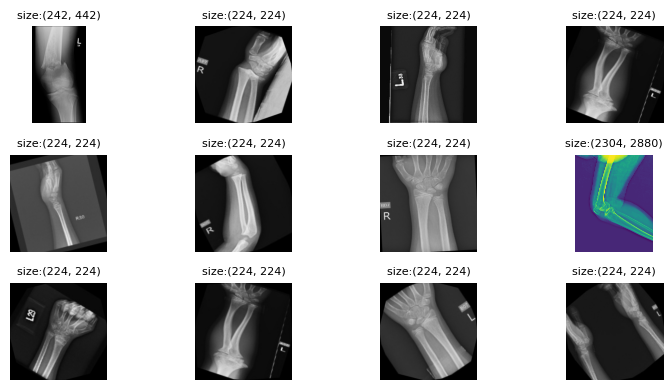

In [5]:
# 4. Display dataset

def display_dataset(path, num_images=12):
    random.seed(322)
    images_paths = get_image_paths(path)
    random_images = random.sample(images_paths, num_images)
    fig, axes = plt.subplots(3, 4, figsize=(8, 4))

    for i, ax in enumerate(axes.flat):
        image_path = random_images[i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"size:{image.size}", fontsize=8)

    plt.tight_layout()
    plt.show()

display_dataset(val_path)

In [6]:
# 5. Handle transparency
class HandleTransparency(object):
    def __call__(self, img):
        if img.mode in ['RGBA', 'LA']:
            img = img.convert('L')
        elif img.mode == 'P':
            img = img.convert('RGBA').convert('L')
        else:
            img = img.convert('L')
        return img


In [7]:
# 6. Transforms
train_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [8]:
# 7. Load datasets
train_ds = ImageFolder(train_path, transform=train_transforms)
val_ds = ImageFolder(val_path, transform=val_transforms)

train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=False)

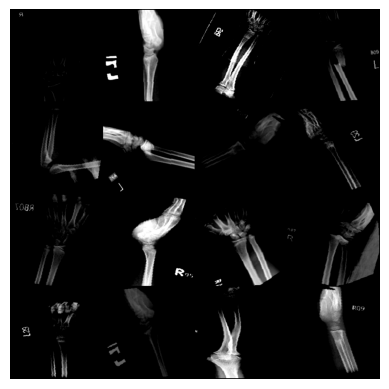

In [9]:
# 8. Show batch images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

dataiter = iter(train_dataloader)
images, _ = next(dataiter)
imshow(vutils.make_grid(images[:16], nrow=4))

In [10]:
# 9. Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
from torchvision.models import densenet121

# 10 Load DenseNet121 từ torchvision
model = densenet121(pretrained=True)

# Sửa lớp đầu vào để nhận ảnh grayscale (1 channel)
model.features.conv0 = nn.Conv2d(
    in_channels=1,
    out_channels=model.features.conv0.out_channels,
    kernel_size=model.features.conv0.kernel_size,
    stride=model.features.conv0.stride,
    padding=model.features.conv0.padding,
    bias=(model.features.conv0.bias is not None)
)

# Đóng băng toàn bộ model
for param in model.parameters():
    param.requires_grad = False

# Cho phép fine-tune DenseBlock cuối
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

# Thay classifier
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 2)
)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 196MB/s]


In [12]:
# 11. Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()

# Chỉ train phần requires_grad=True
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4, 
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

In [13]:
wandb.init(
    project="fracture-classification",
    name="densenet121-3-binary",
    config={
        "model": "densenet121",
        "epochs": 20,
        "batch_size": 64,
        "lr": 1e-4,
        "optimizer": "AdamW",
        "scheduler": "StepLR",
        "loss": "CrossEntropyLoss",
        "dropout": 0.3,
        "image_size": 224,
        "dataset": "Bone_Fracture_Binary"
    }
)

wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250804_234332-wczwdg5o
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run densenet121-3-binary
wandb: ⭐️ View project at https://wandb.ai/hoangviet852004-vku/fracture-classification
wandb: 🚀 View run at https://wandb.ai/hoangviet852004-vku/fracture-classification/runs/wczwdg5o


In [14]:
# 12. Train/validate
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    acc = 100 * correct / len(dataloader.dataset)
    return total_loss / len(dataloader), acc, all_labels, all_preds

def train(model, train_dl, val_dl, criterion, optimizer, scheduler, epochs=20):
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_dl, criterion, optimizer)
        val_loss, acc, labels, preds = validate(model, val_dl, criterion)
        scheduler.step()
        wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss, "val_accuracy": acc})
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Acc {acc:.2f}%")
    return labels, preds

In [15]:
labels, preds = train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler)

 31%|███       | 4/13 [00:03<00:08,  1.09it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


Epoch 1: Train Loss 0.4067 | Val Loss 0.2408 | Acc 89.75%


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


Epoch 2: Train Loss 0.1301 | Val Loss 0.1416 | Acc 93.73%


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch 3: Train Loss 0.0687 | Val Loss 0.1092 | Acc 95.66%


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch 4: Train Loss 0.0468 | Val Loss 0.0778 | Acc 97.83%


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch 5: Train Loss 0.0354 | Val Loss 0.0700 | Acc 97.59%


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch 6: Train Loss 0.0299 | Val Loss 0.0680 | Acc 97.35%


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch 7: Train Loss 0.0280 | Val Loss 0.0826 | Acc 96.98%


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch 8: Train Loss 0.0249 | Val Loss 0.0600 | Acc 97.71%


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


Epoch 9: Train Loss 0.0187 | Val Loss 0.0536 | Acc 97.95%


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


Epoch 10: Train Loss 0.0186 | Val Loss 0.0547 | Acc 98.19%


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


Epoch 11: Train Loss 0.0174 | Val Loss 0.0568 | Acc 98.31%


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch 12: Train Loss 0.0173 | Val Loss 0.0494 | Acc 98.31%


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch 13: Train Loss 0.0175 | Val Loss 0.0427 | Acc 98.67%


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch 14: Train Loss 0.0148 | Val Loss 0.0405 | Acc 98.67%


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch 15: Train Loss 0.0158 | Val Loss 0.0452 | Acc 98.55%


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch 16: Train Loss 0.0133 | Val Loss 0.0426 | Acc 98.67%


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch 17: Train Loss 0.0120 | Val Loss 0.0398 | Acc 98.55%


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch 18: Train Loss 0.0130 | Val Loss 0.0482 | Acc 98.67%


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Epoch 19: Train Loss 0.0107 | Val Loss 0.0470 | Acc 98.67%


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]

Epoch 20: Train Loss 0.0125 | Val Loss 0.0450 | Acc 98.79%


In [16]:
# 13. Save model
os.makedirs("FracturedDataDenseNet", exist_ok=True)
torch.save(model.state_dict(), "FracturedDataDenseNet/model.pt")
wandb.save("FracturedDataDenseNet/model.pt")

['/kaggle/working/wandb/run-20250804_234332-wczwdg5o/files/FracturedDataDenseNet/model.pt']

In [17]:
# 14. Test evaluation
test_ds = ImageFolder(test_path, transform=val_transforms)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

def get_predictions(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = get_predictions(model, test_dl)

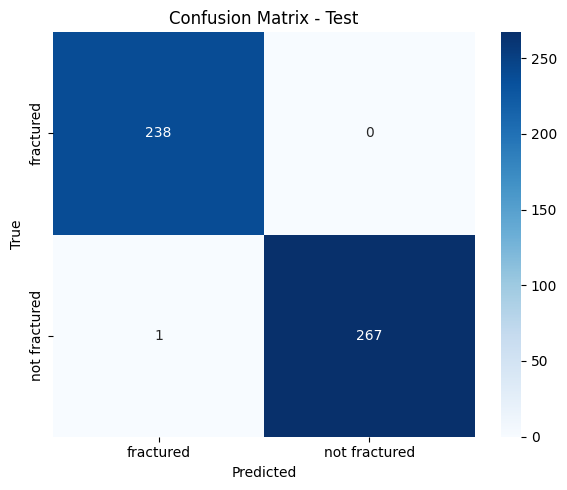

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(pd.DataFrame(cm, index=test_ds.classes, columns=test_ds.classes), annot=True, fmt="d", cmap="Blues", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test")
plt.tight_layout()
wandb.log({"confusion_matrix": wandb.Image(fig)})
plt.show()

In [19]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=test_ds.classes, output_dict=True)
wandb.log({"classification_report": report})
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=test_ds.classes))

=== Classification Report ===
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       238
not fractured       1.00      1.00      1.00       268

     accuracy                           1.00       506
    macro avg       1.00      1.00      1.00       506
 weighted avg       1.00      1.00      1.00       506



In [20]:
# Overall Metrics
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
wandb.log({"test_accuracy": acc, "test_precision": precision, "test_recall": recall, "test_f1": f1})
print("=== Overall Metrics (Macro Average) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

=== Overall Metrics (Macro Average) ===
Accuracy : 0.9980
Precision: 0.9979
Recall   : 0.9981
F1 Score : 0.9980
